# QMC Agent V2 - Debug Notebook (Async/Hybrid)

Este cuaderno permite probar la **Nueva Arquitectura Escalable** paso a paso.
Utiliza los módulos refactorizados en `src/` que también son usados por el script de producción `src/main.py`.

### Novedades V2:
- **Extracción Global**: Carga TODAS las tareas de hoy (paginación automática).
- **Analista LLM**: Usa IA para analizar múltiples procesos (FE_HITOS, FE_COBRANZAS, etc.) en paralelo.
- **Soporte Async**: Ejecución nativa asíncrona.

In [2]:
# 1. Configuración e Importaciones
import sys
import os
from datetime import datetime
import json

# Asegurar que podemos importar src
sys.path.insert(0, os.getcwd())

from src.config import Config
from src.state import create_initial_state
from src.nodes.login_node_sync import login_node_sync
from src.nodes.extractor import extractor_node
from src.nodes.analyst_llm import analyst_llm_node
from src.nodes.reporter import reporter_node
from IPython.display import Image, display

print("✅ Importaciones correctas")
print(f"⚙️ Modo Headless: {Config.HEADLESS}")
print(f"📋 Procesos Monitoreados: {list(Config.MONITORED_PROCESSES.keys())}")

✅ Importaciones correctas
⚙️ Modo Headless: False
📋 Procesos Monitoreados: ['FE_HITOS_DIARIO', 'FE_COBRANZAS_DIARIA', 'FE_PASIVOS', 'FE_PRODUCCION', 'FE_CALIDADCARTERA_DIARIO']


## 2. Inicializar Estado

In [3]:
state = create_initial_state()
print(f"Estado inicial: {state['current_step']}")

Estado inicial: init


## 3. Login (Síncrono)

In [4]:
print("🔑 Iniciando Login...")
login_result = login_node_sync(state)
state.update(login_result)

if state.get("success"):
    print("✅ Login Exitoso")
else:
    print(f"❌ Error Login: {state.get('error_message')}")

🔑 Iniciando Login...
✅ Login Exitoso


## 4. Extracción Global (Last execution = Today)

In [5]:
print("🕷️ Extrayendo TODAS las tareas de hoy (con paginación)...")

# Ejecuta el script V2 que hace el loop de "Show More"
extract_result = extractor_node(state)
state.update(extract_result)

if state.get("current_step") == "error":
    print(f"❌ Error Extracción: {state.get('error_message')}")
else:
    total = len(state.get("structured_data", []))
    print(f"✅ Extracción Completa. Total tareas: {total}")
    # Preview
    if total > 0:
        print("\nEjemplo de tarea:")
        print(json.dumps(state["structured_data"][0], indent=2))

🕷️ Extrayendo TODAS las tareas de hoy (con paginación)...
   [Extractor] Starting extraction (Global Filter)...
   [Extractor] Extracted 727 tasks (Pagination clicks: 2)
✅ Extracción Completa. Total tareas: 727

Ejemplo de tarea:
{
  "Name": "01. CARGA_FACT_DM_VENTA_TRANSFORMACION_V4.0 - MAGENTO",
  "Associated resource": "CARGA_FACT_DM_VENTA_TRANSFORMACION_V4.0 - MAGENTO",
  "Type": "Reload",
  "Enabled": "Yes",
  "Status": "Success",
  "Last execution": "2026-01-30 04:01",
  "Next execution": "On multiple triggers",
  "Tags": "Dif_Monitor_Magento"
}


## 5. Análisis Inteligente con LLM (Asíncrono)

In [6]:
print("🤖 Analizando procesos con LLM...")

# Nota: Jupyter soporta 'await' de nivel superior
analyst_result = await analyst_llm_node(state)
state.update(analyst_result)

print("✅ Análisis Completado")

🤖 Analizando procesos con LLM...
   [Analyst] Starting LLM Analysis...
     > Analyzing FE_HITOS_DIARIO (4 tasks)...
       Result: Running - The process 'FE_HITOS_DIARIO' is currently running as one of its tasks is in the 'Started' state.
     > Analyzing FE_COBRANZAS_DIARIA (4 tasks)...
       Result: Success - All tasks for the process 'FE_COBRANZAS_DIARIA' have completed successfully.
     > Analyzing FE_PASIVOS (1 tasks)...
       Result: Success - All tasks in the FE_PASIVOS process have completed successfully.
     > Analyzing FE_PRODUCCION (6 tasks)...
       Result: Pending - The process is pending due to a queued task.
     > Analyzing FE_CALIDADCARTERA_DIARIO (14 tasks)...
       Result: Pending - The process 'FE_CALIDADCARTERA_DIARIO' is pending due to tasks waiting in the queue.
✅ Análisis Completado


## 6. Reporte Final (Texto)

In [7]:
reports = state.get("process_reports", {})

print(f"📊 Reporte Generado ({len(reports)} procesos detectados):\n")

for tag, rep in reports.items():
    status_emoji = "✅" if rep.get("status") == "Success" else "⚠️" if rep.get("status") == "Warning" else "❌"
    print(f"{status_emoji} {tag}")
    print(f"   Estado: {rep.get('status')}")
    print(f"   Resumen: {rep.get('summary')}")
    if rep.get("failed_tasks"):
        print(f"   🔴 Fallidas: {rep.get('failed_tasks')}")
    print("-" * 30)

📊 Reporte Generado (5 procesos detectados):

❌ FE_HITOS_DIARIO
   Estado: Running
   Resumen: The process 'FE_HITOS_DIARIO' is currently running as one of its tasks is in the 'Started' state.
------------------------------
✅ FE_COBRANZAS_DIARIA
   Estado: Success
   Resumen: All tasks for the process 'FE_COBRANZAS_DIARIA' have completed successfully.
------------------------------
✅ FE_PASIVOS
   Estado: Success
   Resumen: All tasks in the FE_PASIVOS process have completed successfully.
------------------------------
❌ FE_PRODUCCION
   Estado: Pending
   Resumen: The process is pending due to a queued task.
------------------------------
❌ FE_CALIDADCARTERA_DIARIO
   Estado: Pending
   Resumen: The process 'FE_CALIDADCARTERA_DIARIO' is pending due to tasks waiting in the queue.
------------------------------


## 7. Reporte Visual (Imagen)

🖼️ Generando reporte visual...
   [Reporter] Generating Visual Report...
   [Reporter] Report saved to: c:\Users\Lenovo\Documents\agent_qmc\reportes\31_01_2026\qmc_report_20260131_115502.png
✅ Imagen generada: c:\Users\Lenovo\Documents\agent_qmc\reportes\31_01_2026\qmc_report_20260131_115502.png


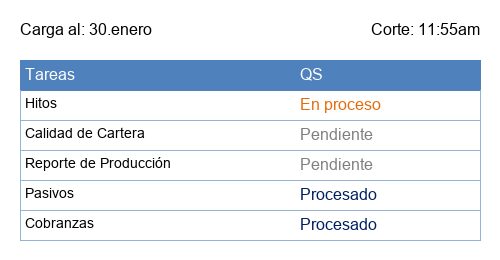

In [9]:
print("🖼️ Generando reporte visual...")
report_result = reporter_node(state)
state.update(report_result)

image_path = state.get("report_image_path")
if image_path and os.path.exists(image_path):
    print(f"✅ Imagen generada: {image_path}")
    display(Image(filename=image_path))
else:
    print("❌ No se pudo generar la imagen")